# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

In [ ]:
!python -m pip install --user --upgrade pip
!pip install pandas-datareader
!pip install tqdm
!pip install xgboost
!pip install lightgbm

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2
from module import *

# Agile분석 결과확인

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


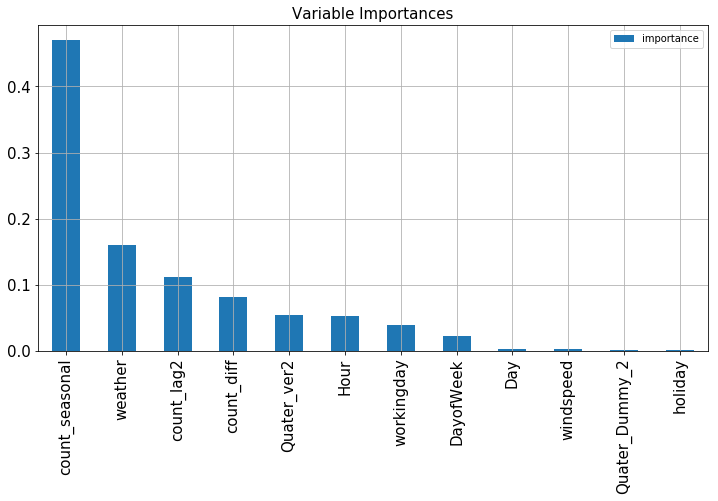

,MAE,MSE,MAPE
Train,6.54,123.38,9.11
Test,51.52,"6,749.92",40.49


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify th

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-16.29,0.40,0.83,986.72,"1,017.92","1,064.70","1,511.67",3.04
p-value,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,27.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,100.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"98,935.70",nan,nan,nan,nan,nan,nan,NaN


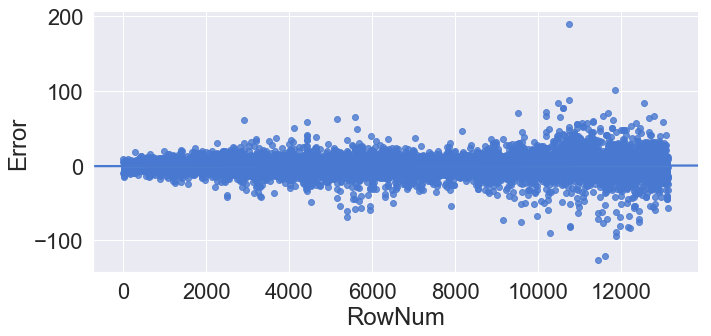

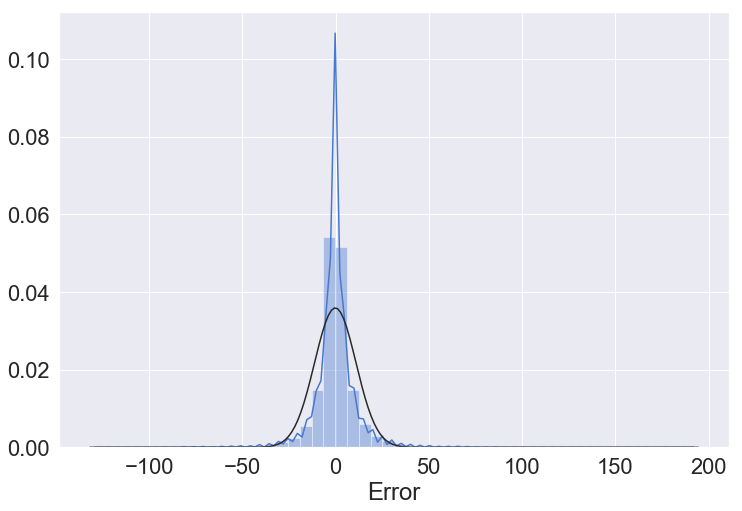

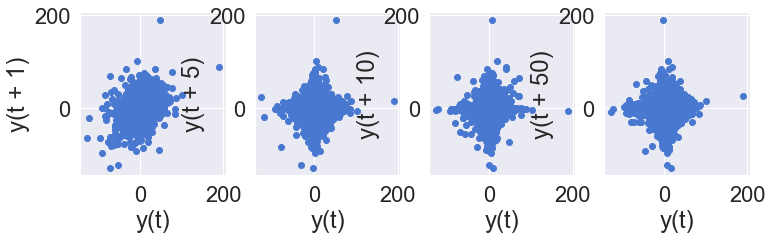

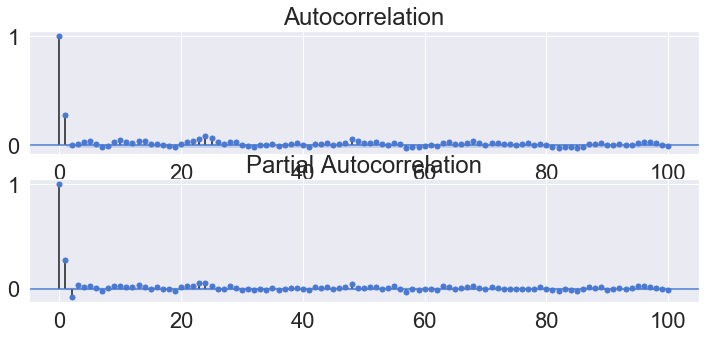

In [2]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# Applying Agile Model
# RandomForestRegressor
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train_feRSM)
pred_te_reg6_feRSM = fit_reg6.predict(X_test_feRSM)

# Prediction Effect of Variables
Variable_Importances = pd.DataFrame([fit_reg6.feature_importances_], 
                                    columns=X_train_feRSM.columns, 
                                    index=['importance']).T.sort_values(by=['importance'], ascending=False)
Variable_Importances.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importances', fontsize=15)
plt.grid()
plt.show()

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

# Error Analysis
error_analysis(Resid_tr_reg6_feRSM, ['Error'], X_train_feRSM, graph_on=True)

# Applying Time Series Model: Y예측을 위한 TS분석 실행

Test Statistics         -6.84
p-value                  0.00
Used Lag                41.00
Used Observations   13,086.00
dtype: float64

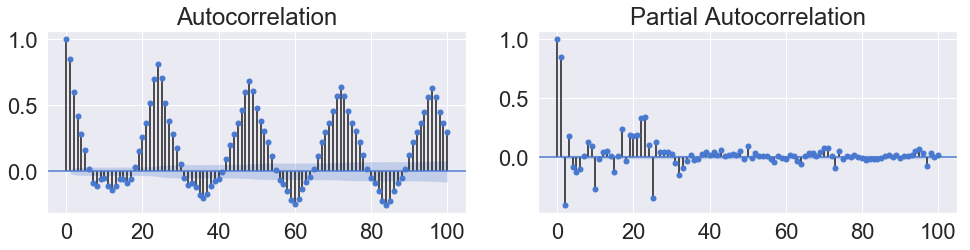

In [3]:
## 정상성 테스트 및 모수추론(p=1, q=1, d=0, P=1, Q=1, D(m)=12)
result = pd.Series(sm.tsa.stattools.adfuller(Y_train_feR.values.flatten())[0:4],
                   index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
display(result)

plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(Y_train_feR, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(Y_train_feR, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

## 수요예측 SARIMA 모델링

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                13128
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood              -74351.487
Date:                            Sat, 06 Jul 2019   AIC                         148714.974
Time:                                    19:43:11   BIC                         148759.869
Sample:                                01-01-2011   HQIC                        148729.967
                                     - 06-30-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0204      0.016      1.258      0.208      -0.011       0.052
ar.L1          0.7235      0.005    131.742      0.000       0.713       0.734
ma.L1          0.5017      0.008     65.302      0.000       0.487       0.517
ar.S.L12       0.9996      0.000   3724.268      0.000       0.999       1.000
ma.S.L12      -0.9830      0.002   -625.305      0.000      -0.986      -0.980
sigma2      4851.0078     48.044    100.971      0.000    4756.844    4945.172
===================================================================================
Ljung-Box (Q):                    14882.10   Jarque-Bera (JB):              3720.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.56   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,MAE,MSE,MAPE
Train,50.64,"4,854.67",159.15
Test,167.64,"42,669.35",559.00


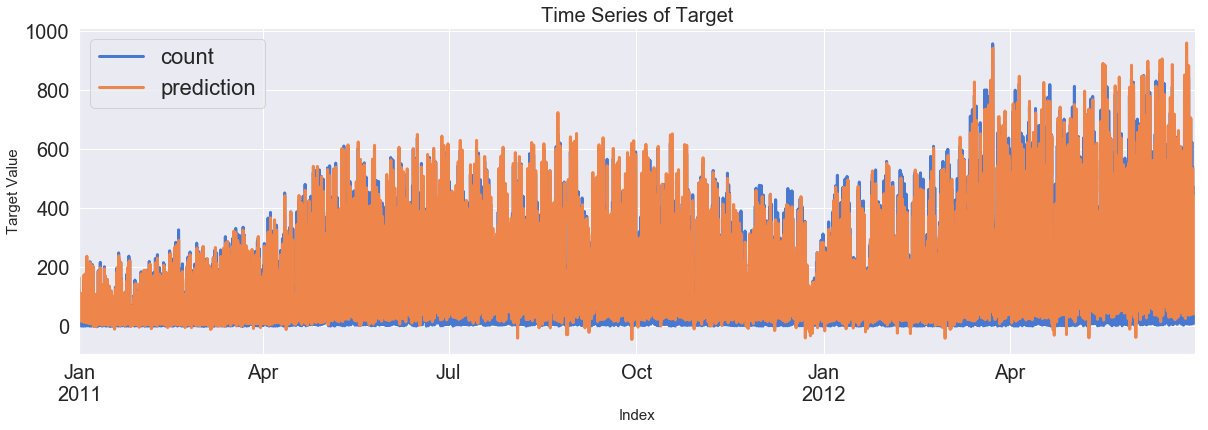

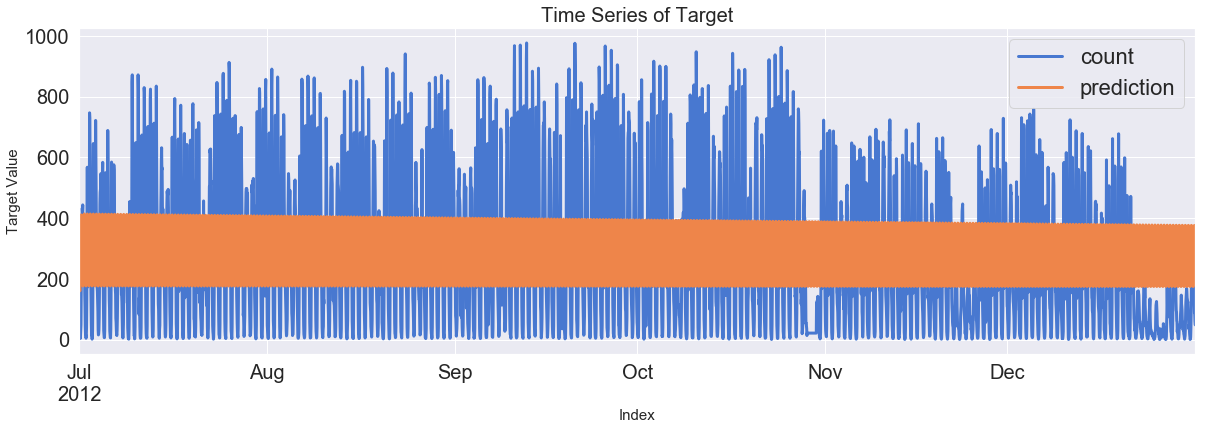

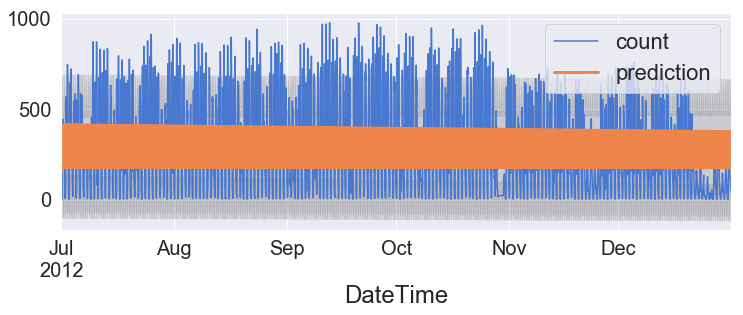

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify th

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-14.65,1.02,0.96,28.81,576.20,"2,003.74","17,431.62",1.70
p-value,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,40.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,087.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"139,502.98",nan,nan,nan,nan,nan,nan,NaN


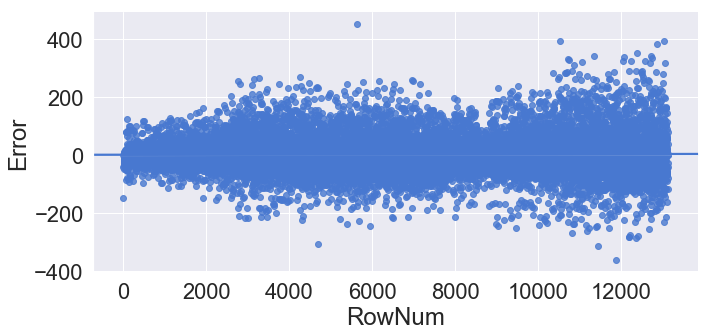

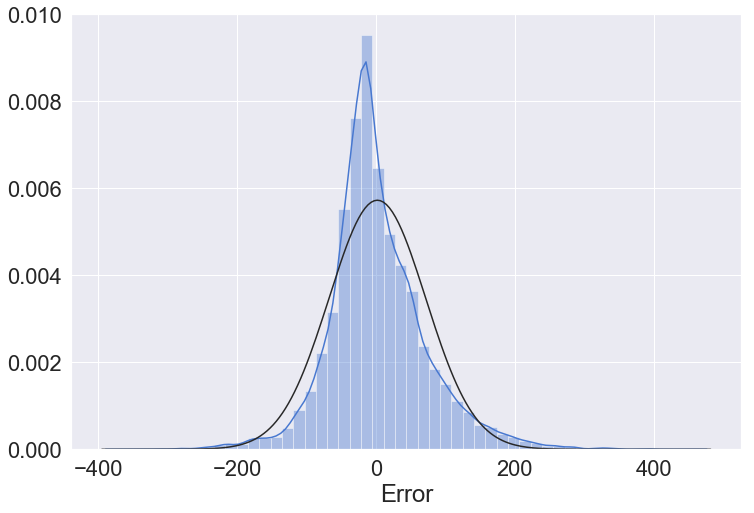

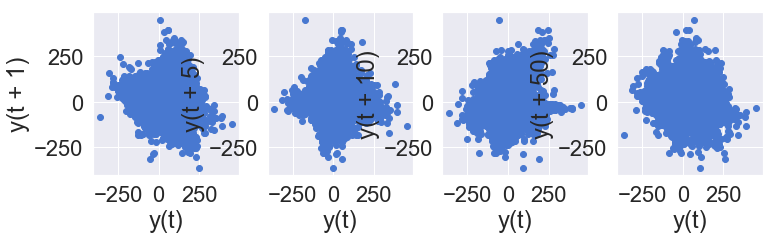

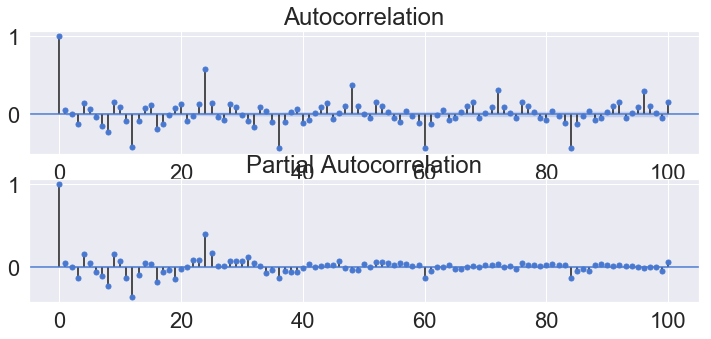

In [4]:
# 모델링
## SARIMA
logarithm, differencing = False, False
trend_diff_order, seasonal_diff_order = 0, 12
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,trend_diff_order,1), 
                                seasonal_order=(1,0,1,seasonal_diff_order)).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR)).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR)).conf_int()
## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(Y_train_feR).copy()
    Y_test = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
if differencing:
    pred_tr_ts_sarimax = np.cumsum(pred_tr_ts_sarimax).copy()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

## 수요예측 SARIMAX 모델링

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                13128
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood              -72557.806
Date:                            Sat, 06 Jul 2019   AIC                         145143.613
Time:                                    19:48:13   BIC                         145248.368
Sample:                                01-01-2011   HQIC                        145178.597
                                     - 06-30-2012                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0010      0.007     -0.146      0.884      -0.015       0.013
count_seasonal  1210.8875     20.086     60.286      0.000    1171.520    1250.255
weather        -1.678e+04      4.124  -4069.403      0.000   -1.68e+04   -1.68e+04
count_lag2      1080.5077     15.434     70.007      0.000    1050.257    1110.758
count_diff      1316.3500     13.483     97.632      0.000    1289.924    1342.776
Quater_ver2     3.292e+04      3.734   8815.491      0.000    3.29e+04    3.29e+04
Hour           -3279.2622    381.583     -8.594      0.000   -4027.151   -2531.373
workingday      7.489e+04      0.214    3.5e+05      0.000    7.49e+04    7.49e+04
DayofWeek       1.594e+04      6.368   2502.732      0.000    1.59e+04    1.59e+04
ar.L1              0.2975      0.011     28.309      0.000       0.277       0.318
ma.L1              0.5779      0.009     61.333      0.000       0.559       0.596
ar.S.L12           1.0000   2.73e-05   3.66e+04      0.000       1.000       1.000
ma.S.L12          -0.9789      0.001   -671.291      0.000      -0.982      -0.976
sigma2          3602.7401     36.138     99.694      0.000    3531.911    3673.569
===================================================================================
Ljung-Box (Q):                     7188.18   Jarque-Bera (JB):             13334.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.49   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.91e+22. Standard errors may be unstable.
"""

,MAE,MSE,MAPE
Train,42.30,"3,687.83",116.89
Test,108.53,"19,648.91",212.71


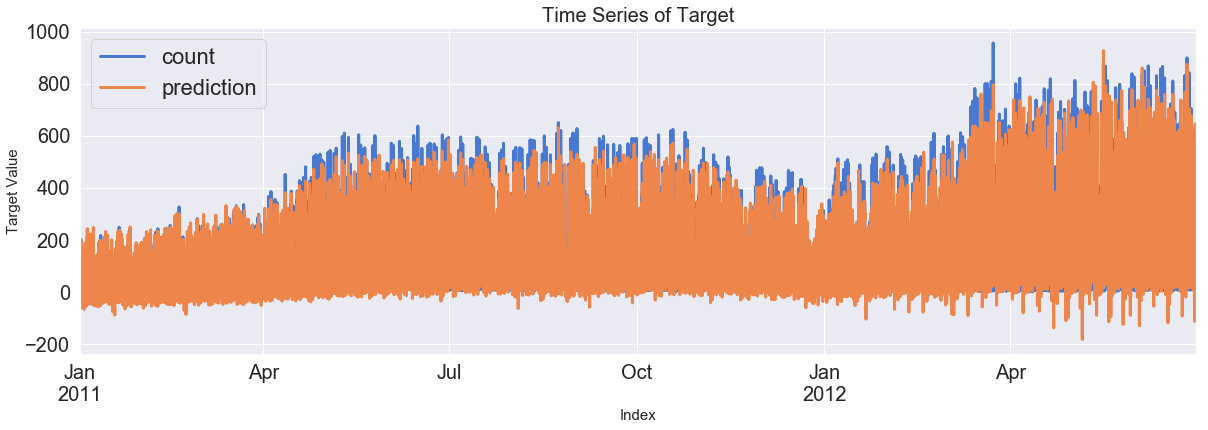

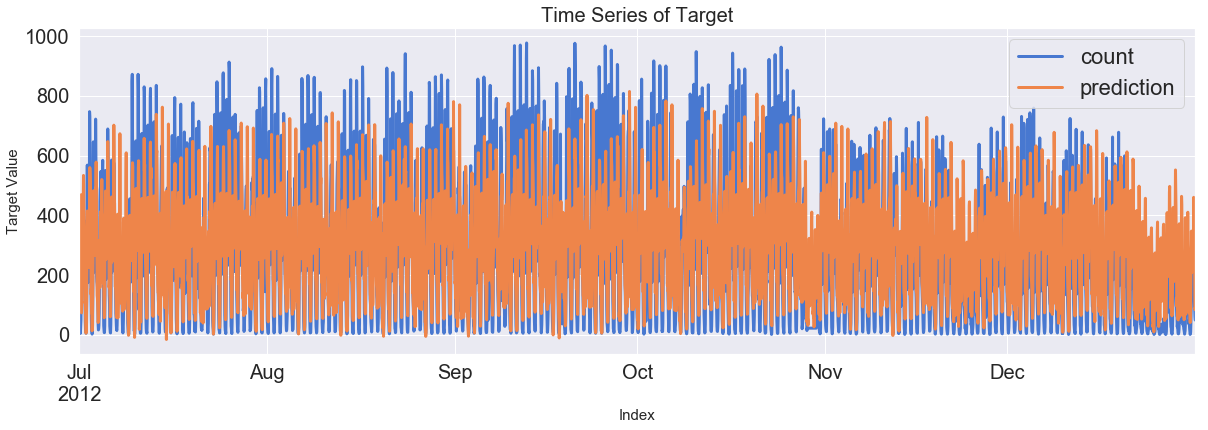

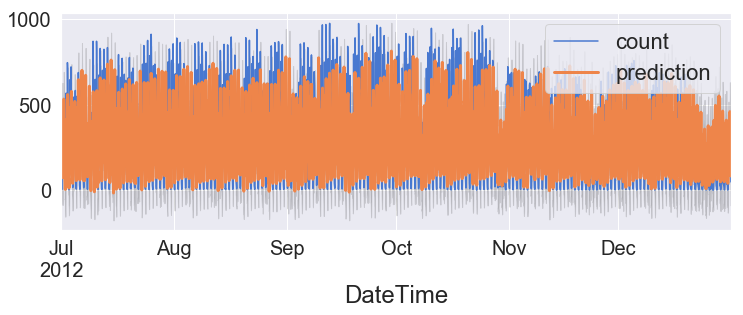

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify th

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-14.59,0.92,0.94,2.94,339.29,"1,945.78","7,657.36",2.31
p-value,0.00,0.01,0.00,0.09,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"139,938.56",nan,nan,nan,nan,nan,nan,NaN


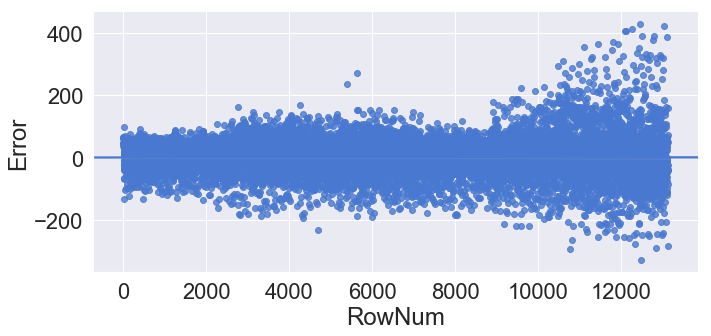

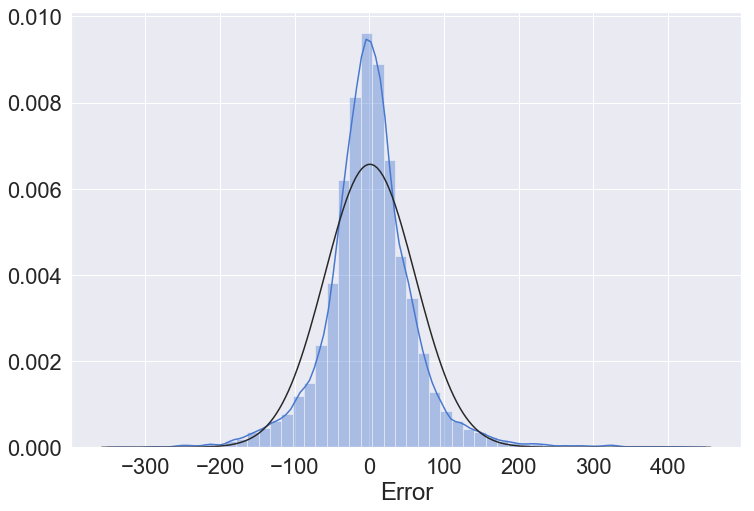

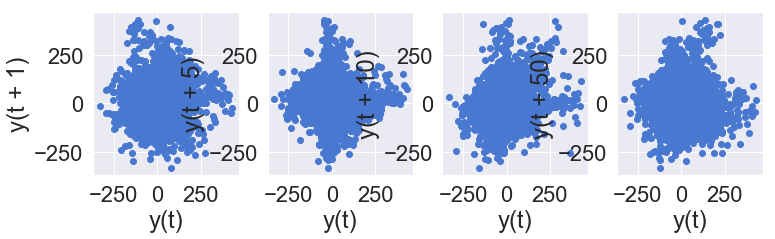

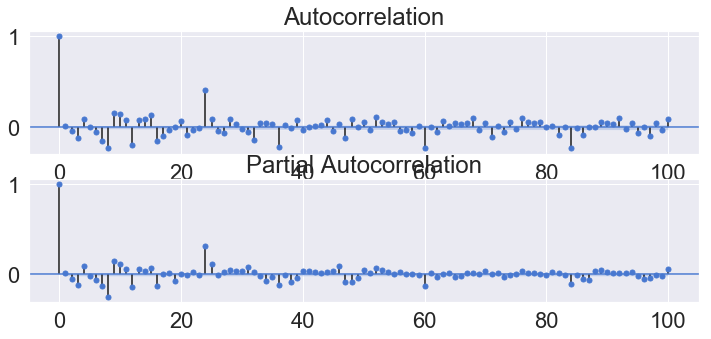

In [5]:
# 모델링
## SARIMAX
logarithm, differencing = False, False
trend_diff_order, seasonal_diff_order = 0, 12
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,trend_diff_order,1), 
                                seasonal_order=(1,0,1,seasonal_diff_order), exog=exog_tr).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).conf_int()
## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(Y_train_feR).copy()
    Y_test = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
if differencing:
    pred_tr_ts_sarimax = np.cumsum(pred_tr_ts_sarimax).copy()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

## 수요예측 Auto-SARIMAX 모델링

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 1, 1, 12) AIC=141832.52809593524, BIC=141937.27032986673


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 1, 2, 12) AIC=141408.26678123462, BIC=141520.4906033041


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 1, 1, 12) AIC=141058.36769167258, BIC=141170.59151374205


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 1, 2, 12) AIC=141278.58913070807, BIC=141398.29454091552


 25%|████████████████████▊                                                              | 1/4 [16:19<48:58, 979.39s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(1, 1, 1, 12) AIC=142426.63517476205, BIC=142538.85899683152


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(1, 1, 2, 12) AIC=141381.17868380973, BIC=141500.88409401718


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(2, 1, 1, 12) AIC=141188.63528324844, BIC=141308.3406934559


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(2, 1, 2, 12) AIC=141256.68785446676, BIC=141383.87485281215


 50%|█████████████████████████████████████████                                         | 2/4 [34:47<33:56, 1018.06s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(1, 1, 1, 12) AIC=142430.59254074068, BIC=142542.81636281015


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(1, 1, 2, 12) AIC=141382.69688890647, BIC=141502.40229911392


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(2, 1, 1, 12) AIC=141068.24815460187, BIC=141187.95356480932


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(2, 1, 2, 12) AIC=141270.9078390748, BIC=141398.09483742018


 75%|█████████████████████████████████████████████████████████████▌                    | 3/4 [50:58<16:43, 1003.78s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(1, 1, 1, 12) AIC=142426.3231299178, BIC=142546.02854012523


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(1, 1, 2, 12) AIC=141402.3510917197, BIC=141529.5380900651


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(2, 1, 1, 12) AIC=140953.30596294272, BIC=141080.4929612881


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(2, 1, 2, 12) AIC=141129.66513823983, BIC=141264.3337247232


100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:07:48<00:00, 1005.63s/it]


The smallest AIC is 140953.30596294272 for model SARIMAX(2, 0, 2)x(2, 1, 1, 12)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                13128
Model:             SARIMAX(2, 0, 2)x(2, 1, 1, 12)   Log Likelihood              -70459.653
Date:                            Sat, 06 Jul 2019   AIC                         140953.306
Time:                                    21:01:18   BIC                         141080.493
Sample:                                01-01-2011   HQIC                        140995.784
                                     - 06-30-2012                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          1.0872      0.098     11.049      0.000       0.894       1.280
count_seasonal  1378.1390     30.685     44.913      0.000    1317.998    1438.280
weather        -3.875e+04   1698.507    -22.814      0.000   -4.21e+04   -3.54e+04
count_lag2       396.3120     20.254     19.567      0.000     356.615     436.009
count_diff      1006.0433     10.709     93.946      0.000     985.054    1027.032
Quater_ver2    -6.417e+05   8170.613    -78.541      0.000   -6.58e+05   -6.26e+05
Hour           -1559.8433    638.321     -2.444      0.015   -2810.930    -308.757
workingday     -2118.5354   7089.075     -0.299      0.765    -1.6e+04    1.18e+04
DayofWeek        371.0573   1702.642      0.218      0.827   -2966.059    3708.174
ar.L1             -0.4670      0.011    -42.605      0.000      -0.488      -0.446
ar.L2              0.4605      0.009     53.894      0.000       0.444       0.477
ma.L1              1.4781      0.012    128.003      0.000       1.455       1.501
ma.L2              0.4875      0.011     45.887      0.000       0.467       0.508
ar.S.L12          -0.0219      0.008     -2.676      0.007      -0.038      -0.006
ar.S.L24           0.4254      0.006     73.206      0.000       0.414       0.437
ma.S.L12          -0.9427      0.004   -254.337      0.000      -0.950      -0.935
sigma2          2707.7424     23.116    117.135      0.000    2662.435    2753.050
===================================================================================
Ljung-Box (Q):                     2517.83   Jarque-Bera (JB):             55888.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.49   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.1e+14. Standard errors may be unstable.
"""

,MAE,MSE,MAPE
Train,33.99,"2,859.05",103.80
Test,156.60,"40,067.61",294.95


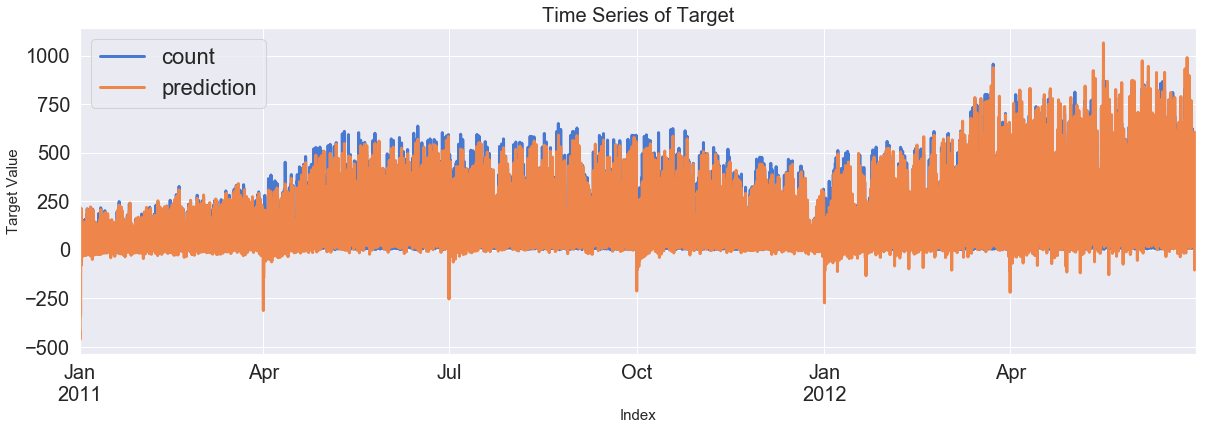

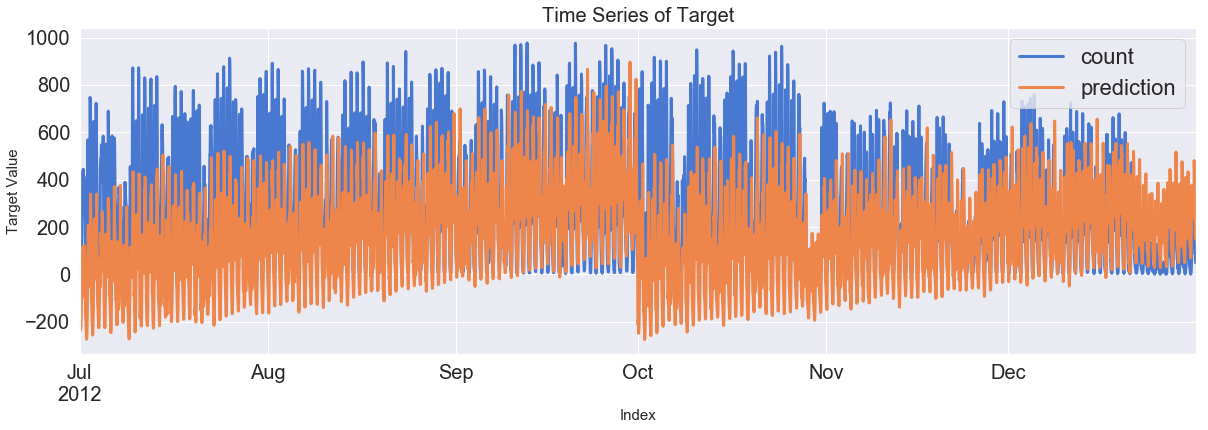

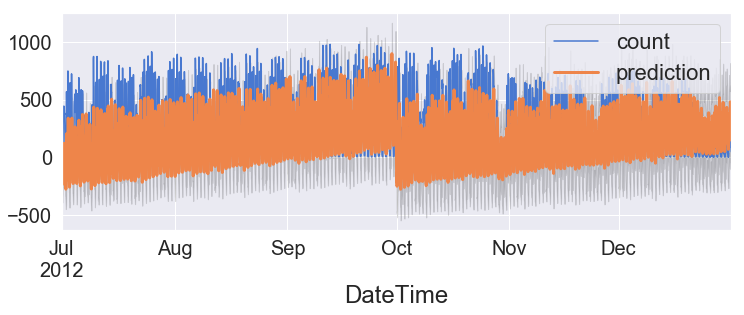

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify th

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-10.24,0.17,0.87,38.00,309.87,"1,315.98","3,031.95",2.45
p-value,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"138,521.40",nan,nan,nan,nan,nan,nan,NaN


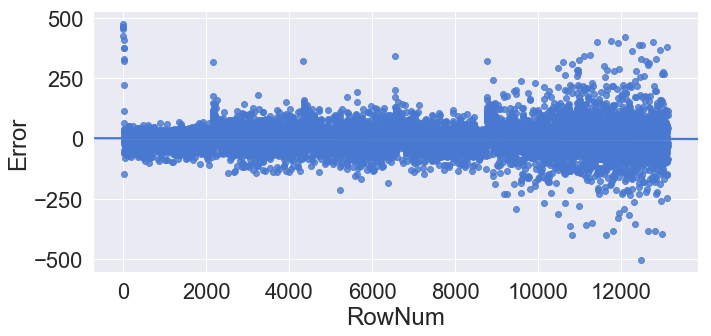

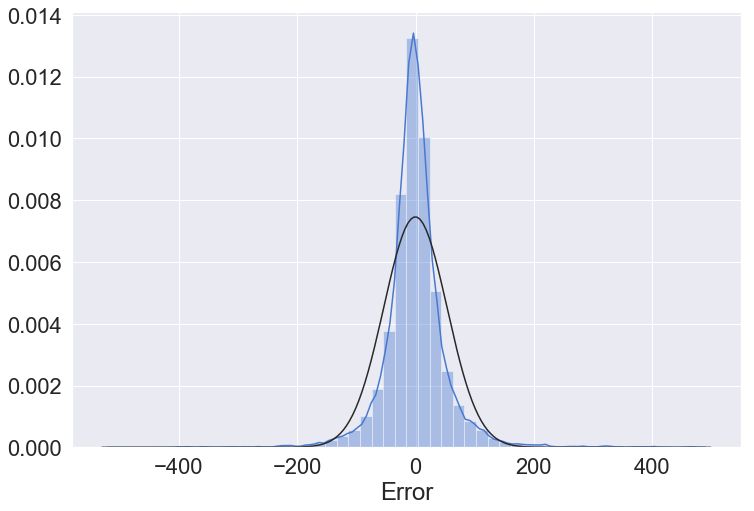

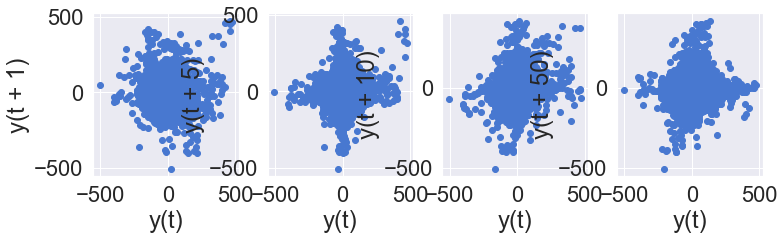

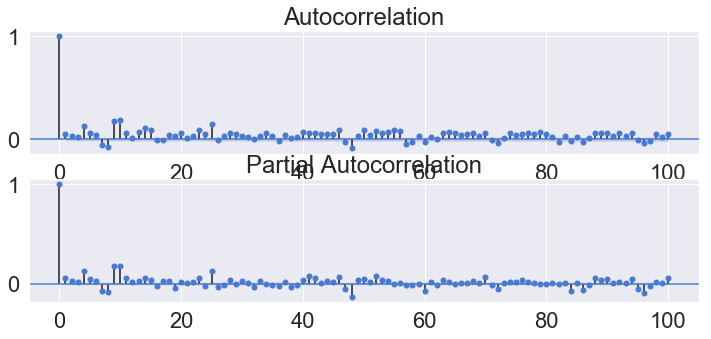

In [6]:
# 모델링
## Parameter Setting
p, q = range(1,3), range(1,3)
d = range(0,1)
P, Q = range(1,3), range(1,3)
D = range(1,2)
m = 12
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi in list(product(P, D, Q))]
## Auto-SARIMAX
logarithm, differencing = False, False
trend_diff_order, seasonal_diff_order = 0, 12
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result =sm.tsa.SARIMAX(Y_train_feR, trend='c', 
                                   order=trend_param, seasonal_order=seasonal_params, exog=exog_tr).fit()
            print('Fit SARIMAX: trend_order={} seasonal_order={} AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, result.bic, end='\r'))
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0],
                                                             SARIMAX_order[AIC.index(min(AIC))][1]))
## Auto-SARIMAX Fitting
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order=SARIMAX_order[AIC.index(min(AIC))][1], exog=exog_tr).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).conf_int()
## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(Y_train_feR).copy()
    Y_test = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
if differencing:
    pred_tr_ts_sarimax = np.cumsum(pred_tr_ts_sarimax).copy()

# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

## 수요예측 Auto-ARIMA 모델링

In [7]:
# # 모델링
# ## Auto-ARIMA
# logarithm, differencing = False, False
# trend_diff_order, seasonal_diff_order = 0, 12
# exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
# exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
# fit_ts_autoarima = auto_arima(Y_train_feR, exogenous=exog_tr, stationary=False,
#                               trend='c', start_p=0, start_q=0, max_p=2, max_q=2, max_d=1,
#                               seasonal=True, start_P=0, start_Q=0, max_P=1, max_Q=1, m=seasonal_diff_order,
#                               stepwise=True, trace=True)
# display(fit_ts_autoarima.summary())
# pred_tr_ts_autoarima = fit_ts_autoarima.predict_in_sample(exogenous=exog_tr)
# pred_te_ts_autoarima = fit_ts_autoarima.predict(len(Y_test_feR), exogenous=exog_te, return_conf_int=True)[0]
# pred_te_ts_autoarima_ci = fit_ts_autoarima.predict(len(Y_test_feR), exogenous=exog_te, return_conf_int=True)[1]
# ## 비정상성으로 변환
# if logarithm:
#     Y_train = np.exp(Y_train).copy()
#     Y_test = np.exp(Y_test).copy()
#     pred_tr_ts_autoarima = np.exp(pred_tr_ts_autoarima).copy()
#     pred_te_ts_autoarima = np.exp(pred_te_ts_autoarima).copy()
#     pred_te_ts_autoarima_ci = np.exp(pred_te_ts_autoarima_ci).copy()
# if differencing:
#     pred_tr_ts_autoarima = np.cumsum(pred_tr_ts_autoarima).copy()
    
# # 검증
# Score_ts_autoarima, Resid_tr_ts_autoarima, Resid_te_ts_autoarima = evaluation_trte(Y_train_feR, pred_tr_ts_autoarima, 
#                                                                              Y_test_feR, pred_te_ts_autoarima, graph_on=True)
# display(Score_ts_autoarima)
# ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
# pd.DataFrame(pred_te_ts_autoarima, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
#                                                                            xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
#                                                                            linewidth=3, fontsize=20, ax=ax)
# ax.fill_between(pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).index,
#                 pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,0],
#                 pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
# plt.show()

# # 잔차진단
# error_analysis(Resid_tr_ts_autoarima, ['Error'], Y_train_feR, graph_on=True)
